In [1]:
# import cv2 
# import numpy as np
# import glob
# import os
# from itertools import combinations 
# from itertools import product
# import random
# import matplotlib.pyplot as plt
# from random import randrange
# import sys
# import math
#apt install python-pydot python-pydot-ng graphviz

In [1]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt
from random import randrange
import sys
import math
import pandas as pd
#apt install python-pydot python-pydot-ng graphviz

In [3]:
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install pydotplus
!{sys.executable} -m pip install graphviz
!{sys.executable} -m pip install xlrd==1.2.0

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |################################| 278 kB 4.7 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=8093aa7fbeb3d0dbd60f02642128224b8017278e828f66cbbbc72a5e3a065d75
  Stored in directory: /root/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |################################| 103 kB 4.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten,Conv2D,Conv2DTranspose,Lambda,concatenate,GlobalMaxPooling2D,Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
#from keras.initializers.h as 
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2 
from pandas import read_excel
import pydot
!{sys.executable} -m pip install tensorflow-addons
import tensorflow_addons as tfa
from pandas import read_excel

ModuleNotFoundError: No module named 'pydot'

In [5]:
path_input_images =  '/tensorflow/IITD_Database/'

In [6]:
#mask_path  = '/tensorflow/iit_unet/mask_data/'
data_in_labels_path  = '/tensorflow/accurate_iitd.csv'

In [7]:
#data = read_excel(data_in_labels_path, sheet_name='Sheet1')

data = pd.read_csv(data_in_labels_path)

In [8]:
data.head()

,image_name,R1p,Y1p,X1p,R1s,Y1s,X1s
0,001_01.bmp,45,131,143,98,132,148
1,001_02.bmp,46,147,133,98,147,138
2,001_03.bmp,47,146,133,98,146,137
3,001_04.bmp,47,153,126,98,153,130
4,001_05.bmp,47,150,122,98,149,126


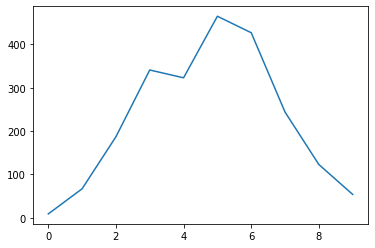

In [9]:
hist_p  = np.histogram(data['R1p'])
hist_s = np.histogram(data['R1s'])

hist_p[0].shape
plt.plot(hist_p[0])
# plt.show()
#print(np.max(data['Y1p']))
#hist_s = np.histogram(data['Y1s'],255)
#print(np.max(data['Y1s']))

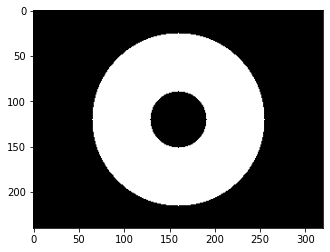

In [7]:
def generate_mask():
    mask_img = np.zeros((240,320,3),dtype='uint8')
    generate_r  = randrange(30,55)

    generate_s  = randrange(generate_r+50,105)


    center = (160,120)
    
    ## outer circle
    mask1 = cv2.circle(mask_img, center, generate_s,(255,255,255),-1)
    ## inner circle 
    mask2 = cv2.circle(mask1, center, generate_r,(0,0,0),-1)

    return mask2

mask2 = generate_mask()
plt.imshow(mask2)
plt.show()

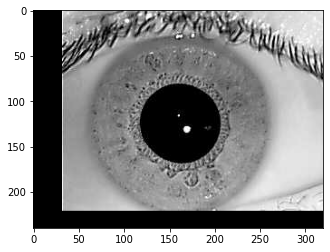

In [11]:
# img_path = '/tensorflow/IITD_Database/001/01.bmp'
# img = cv2.imread(img_path)

def translate_to_center(img):

    ret2,th2 = cv2.threshold(img[:,:,0],0,255,cv2.THRESH_BINARY)

    [h,w] = th2.shape

    col_list = []
    row_list = []

    #find the gravity of image
    for i in range(h):

        for j in range(w):

            if(th2[i,j]==0):

                col_list.append(j)
                row_list.append(i)

    center_col = round(np.mean(col_list))
    center_row = round(np.mean(row_list))

    T_col = round(w/2 - round(np.mean(col_list)))
    T_row = round(h/2 - round(np.mean(row_list)))


    T = np.float32([[1, 0, T_col], [0, 1, T_row]])

    # We use warpAffine to transform
    # the image using the matrix, T
    img_translation = cv2.warpAffine(img, T, (w, h))
    
    return img_translation



#print(center_col,center_row)
img_path = '/tensorflow/IITD_Database/001/01.bmp'
img = cv2.imread(img_path)
img_translation = translate_to_center(img)
plt.imshow(img_translation,cmap='gray')
plt.show()

In [12]:
randrange(100,150)

102

In [13]:
def change_name(name):
    d = name.split('/')
    mask_name = 'frame' + '_' + d[0]+'_'+d[1] +'.png'
    return mask_name


In [14]:
#rows = data[data['image_name']=='001_04.bmp']

In [15]:
#rows['Y1p'].iloc[0]

In [16]:
def read_simaese_parametric_data(path_input_images, folder_name_list_batch,batch_size):
    
    
    h  = 128
    w = 128 
    c = 1
    factor  = 4
    
    train_out1 = np.zeros((factor*batch_size,h,w,c),'float')
    train_out2 = np.zeros((factor*batch_size,h,w,c),'float')
    train_seg1 = np.zeros((factor*batch_size,h,w,1),'float')
    train_seg2 = np.zeros((factor*batch_size,h,w,1),'float')
    
    out1= np.zeros((factor*batch_size,h,w,c),'float')
    out2= np.zeros((factor*batch_size,h,w,c),'float')
    
    seg1= np.zeros((factor*batch_size,h,w,1),'float')
    seg2= np.zeros((factor*batch_size,h,w,1),'float')
    
    pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
    pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

    neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
    #
    count = 0
    y = []
    
    for folder_name in folder_name_list_batch:

        for j in range (len(pos_comb1)-9):
           
            i = random.randint(0, 9)
        
            ## read the image from folder in postive combination 
            #print('pos_combi =' + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img1_0 = translate_to_center(img1_0)
            
            img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
#             print('pos_combi =' + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
            img1_1 = translate_to_center(img1_1)
    
            img1_0 = cv2.resize(img1_0[:,:,0],(h,w))    #c = 1
            img1_1 = cv2.resize(img1_1[:,:,0],(h,w))
            ##get the correspondance segmentation data 
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)
            seg1_0 = generate_mask()
            seg1_1 = generate_mask()
            ###############################################################
            seg1_0 = cv2.cvtColor(seg1_0,cv2.COLOR_BGR2GRAY)
            seg1_1 = cv2.cvtColor(seg1_1,cv2.COLOR_BGR2GRAY)
            
            seg1_0 = cv2.resize(seg1_0,(h,w))
            seg1_1 = cv2.resize(seg1_1,(h,w))
            
            ## save the image data to out and out2         
            out1[count]  = np.expand_dims(img1_0,axis=2) #img1_0
            out2[count]  = np.expand_dims(img1_1,axis=2) #img1_1
            seg1[count]  = np.expand_dims(seg1_0,axis=2)
            seg2[count]  = np.expand_dims(seg1_1,axis=2)
            
            #save the segmentation data to lable 

            
            ## posive combination assigning 0 to last clolumn
            y.append(1.0)
            
            ## increament the count
            count = count+1
            
            

            img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
            img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
            
            img2_0 = translate_to_center(img2_0)
            img2_1 = translate_to_center(img2_1)
            
            img2_0 = cv2.resize(img2_0[:,:,0],(h,w)) ## C = 1
            img2_1 = cv2.resize(img2_1[:,:,0],(h,w))  ## c = 1
            
            name1 = folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)
            seg2_0 = generate_mask()
            seg2_1 = generate_mask()
            
            seg2_0 = cv2.cvtColor(seg2_0,cv2.COLOR_BGR2GRAY)
            seg2_1 = cv2.cvtColor(seg2_1,cv2.COLOR_BGR2GRAY)
            seg2_0 = cv2.resize(seg2_0,(h,w))
            seg2_1 = cv2.resize(seg2_1,(h,w))
            out1[count]  = np.expand_dims(img2_0,axis=2)#img2_0
            out2[count]  = np.expand_dims(img2_1,axis=2)#img2_1
            seg1[count]  = np.expand_dims(seg2_0,axis=2)
            seg2[count]  = np.expand_dims(seg2_1,axis=2)          

            y.append(1.0)
            count = count+1

            
            ## negative combination left vs right iris for same person 
            folder_name2 = str(int(folder_name) + 1).zfill(3)
#             print('neg_combi =' + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
#             print('neg_combi =' + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_1 = cv2.imread(path_input_images + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
        
            img3_0 = translate_to_center(img3_0)
            img3_1 = translate_to_center(img3_1)
            img3_0 = cv2.resize(img3_0[:,:,0],(h,w))  #c = 1
            img3_1 = cv2.resize(img3_1[:,:,0],(h,w))
            
            name1 = folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)
            seg3_0 = generate_mask()
            seg3_1 = generate_mask()
            
            seg3_0 = cv2.cvtColor(seg3_0,cv2.COLOR_BGR2GRAY)
            seg3_1 = cv2.cvtColor(seg3_1,cv2.COLOR_BGR2GRAY)
            
            seg3_0 = cv2.resize(seg3_0,(h,w))
            seg3_1 = cv2.resize(seg3_1,(h,w))
            
            out1[count]  = np.expand_dims(img3_0,axis=2) #img3_0
            out2[count]  = np.expand_dims(img3_1,axis=2) #img3_1
            seg1[count]  = np.expand_dims(seg3_0,axis=2)
            seg2[count]  = np.expand_dims(seg3_1,axis=2)
            ## assigning 1 to negative combinations (left vs right image)
            y.append(0.0)
            count = count+1

            
            ## creating the negativ combination from diffrent person 
            folder_name1 = str(int(folder_name) + 3).zfill(3) 
            img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')

            img4_0 = translate_to_center(img4_0)
            img4_1 = translate_to_center(img4_1)
            
            img4_0 = cv2.resize(img4_0[:,:,0],(h,w))
            img4_1 = cv2.resize(img4_1[:,:,0],(h,w))
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)
            seg4_0 = generate_mask()
            seg4_1 = generate_mask()

            seg4_0 = cv2.cvtColor(seg4_0,cv2.COLOR_BGR2GRAY)
            seg4_1 = cv2.cvtColor(seg4_1,cv2.COLOR_BGR2GRAY)        

            seg4_0 = cv2.resize(seg4_0,(h,w))
            seg4_1 = cv2.resize(seg4_1,(h,w))
            
            out1[count]  = np.expand_dims(img4_0,axis=2)#img4_0
            out2[count]  = np.expand_dims(img4_1,axis=2) #img4_1
            seg1[count]  = np.expand_dims(seg4_0,axis=2)
            seg2[count]  = np.expand_dims(seg4_1,axis=2)
            y.append(0.0)
            count = count+1
            #print(i)
            
    ## this padding the data set for size 256x512 to maintain spect rationa nd segmentation parameters 
    train_out1 = out1
    train_out2 = out2 
    
    train_seg1 = seg1
    train_seg2 = seg2  
    
    
#     train_out1[:,0:240,0:320,:] = out1
#     train_out2[:,0:240,0:320,:] = out2 
    
#     train_seg1[:,0:240,0:320,:] = seg1
#     train_seg2[:,0:240,0:320,:] = seg2     
    
    return train_out1,train_out2,train_seg1,train_seg2,y
        #print(count) 

In [17]:
#print(np.array(list(product([2,3,4,5], [8,9,10]))))
print(np.array(list(combinations([1, 2, 3, 4, 5], 2))))


[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 3]
 [2 4]
 [2 5]
 [3 4]
 [3 5]
 [4 5]]


In [18]:
#fileList = listOfFiles     
def imageLoader(path_input_images,folder_name_list,batch_size):

    L = len(folder_name_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = randrange(L-batch_size)
        batch_end = batch_start + batch_size

        if (batch_end < L):
            limit = min(batch_end, L)
            train_out1,train_out2,train_seg1,train_seg2,y_class = read_simaese_parametric_data(path_input_images,folder_name_list[batch_start:limit],batch_size)
            train_out1 = train_out1/255.
            train_out2 = train_out2/255.
            train_seg1 = train_seg1/255.
            train_seg2 = train_seg2/255.
            batch_start = batch_end
            batch_end = batch_start + batch_size
            #print(batch_start,batch_end)
            ## just for the test 
            #yield (train_out2,train_seg2)
            ## original
            yield ([train_out1,train_out2],[train_seg1,train_seg2,np.array(y_class)]) #a tuple with two numpy arrays with batch_size samples     

In [19]:
folder_names = np.sort(os.listdir(path_input_images))
folder_name_list = folder_names[0:180] 
folder_name_list_test = folder_names[180:220]
print(len(folder_name_list_test))

40


### Function to check the GT and loader 

In [20]:
def draw_haugh_circle(img_L,img_R, hough_param):        
    
    
    print('pair_classification =', int(hough_param[12]))
    cimg = img_L.copy()
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),int(hough_param[2]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),int(hough_param[5]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),2,(0,0,255),3)
    plt.title('left_image')
    plt.imshow(cimg)
    plt.show()
    
    
    cimg = img_R.copy()
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),int(hough_param[8]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),int(hough_param[11]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),2,(0,0,255),3)
    plt.title('right_image')
    plt.imshow(cimg)
    plt.show()

In [21]:
g=0
while (g < 10):

    Out = next(imageLoader(path_input_images,folder_name_list,4))
    g = g+1


In [22]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]

mask_L_R_class = Out[1]

mask_L = mask_L_R_class[0]
mask_R = mask_L_R_class[1]
y = mask_L_R_class[2]
print(y[0])
print(image_L.shape)

1.0
(16, 128, 128, 1)


# mask_L.shape

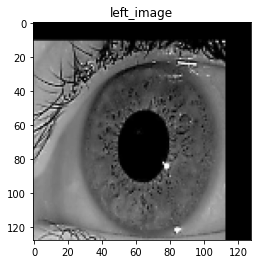

In [23]:
plt.title('left_image')
plt.imshow(image_R[1],cmap='gray')
plt.show()

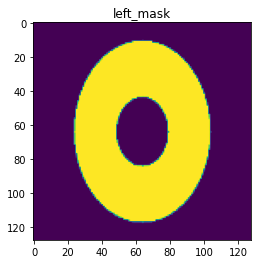

In [24]:
plt.title('left_mask')
plt.imshow(np.squeeze(mask_R[1]))
plt.show()

In [25]:
#pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
#pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

#neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
#print(neg_comb1)

In [26]:
folder_names = np.sort(os.listdir(path_input_images))

print(folder_names[0:20])

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020']


In [27]:
# def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
#     """Function to add 2 convolutional layers with the parameters passed to it"""
#     # first layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     # second layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     return x

In [28]:
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [29]:
def base_network_unet():
    input = Input(shape=(128,128,1), name="base_input")
    n_filters=16
    dropout=.1
    batchnorm=True
       
    c1 = Conv2D(n_filters*1, (3,3), activation='relu',
                   kernel_initializer=initialize_weights,padding = 'same', kernel_regularizer=l2(2e-4))(input)
    p1 = MaxPooling2D((2,2))(c1)           # (h/2,w/2,16)
    p1 = Dropout(dropout)(p1) 

    c2 = Conv2D(n_filters*2, (3,3), activation='relu',
                   kernel_initializer=initialize_weights,padding = 'same', kernel_regularizer=l2(2e-4))(p1)
    p2 = MaxPooling2D((2,2))(c2)  # (h/4,w/4,32)
    p2 = Dropout(dropout)(p2) 

    c3 = Conv2D(n_filters*4, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(p2)
    p3 = MaxPooling2D((2,2))(c3)  # (h/8,w/8,64)
    p3 = Dropout(dropout)(p3) 

    c4 = Conv2D(n_filters*8, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(p3)
    p4 = MaxPooling2D((2,2))(c4)  # (h/16,w/16,128)
    p4 = Dropout(dropout)(p4) 

    c5 = Conv2D(n_filters*16, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(p4)      # (h/16,w/16,256)


    print("encoder done")


    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)  # (h/8,w/8,128)
    u6 = concatenate([u6, c4])   # (h/8,w/8,128)
    u6 = Dropout(dropout)(u6)
        
    c6 = Conv2D(n_filters*8, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(u6) # (h/8,w/8,128)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)  # (h/4,w/4,64)
    u7 = concatenate([u7, c3])   # (h/8,w/8,128)
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D(n_filters*4, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(u7) # (h/4,w/4,64)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)  # (h/2,w/2,32)
    u8 = concatenate([u8, c2])   # (h/2,w/2,32)
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D(n_filters*2, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(u8)     # (h/2,w/2,32)

    u9 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c8)  # (h,w,16)
    u9 = concatenate([u9, c1])   # (h,w,16)
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D(n_filters, (3,3), activation='relu',
                   kernel_initializer=initialize_weights, padding = 'same', kernel_regularizer=l2(2e-4))(u9)     # (h,w,16)    


    print("decoder done . . .  siamese network will start" )
    X_outputs = Conv2D(1,(1,1),activation='sigmoid',name='seg_out')(c9)
   
    print("simaese model done")
    return Model(inputs=input, outputs=[X_outputs,c9])
    
    

In [30]:
def base_network_siamese():
    
    input = Input(shape=(128,128,16), name="base_input")
#     degrees  = tf.constant(0,dtype='float32')
#     r1 = tfa.image.rotate(input[0],input[1])
    
    c10 = Conv2D(64, (10,10), activation='relu',
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))(input)
    p10 = MaxPooling2D()(c10)
    
#     r10 = tfa.image.rotate(p10,degrees, interpolation='BILINEAR')
    
    c11 = Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p10)
    p11 = MaxPooling2D()(c11)
    c12 = Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p11)
    p12 = MaxPooling2D()(c12)
    c13 = Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(p12)
    a1 = Flatten()(c13)
    a2 = Dense(128, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(a1)  
    
    print("simaese model done")
    return Model(inputs=input, outputs=a2)

In [31]:
def euclidean_distance(vects):
    x, y = vects
    
    x0, x1, x2, x3, x4 = tf.split(x, num_or_size_splits=5, axis=1)
    
    y0, y1, y2, y3, y4 = tf.split(y, num_or_size_splits=5, axis=1)

#     v_size =128
#     sum_square_1 = K.sum(K.square(x[0:128] - y[0:128]), axis=1, keepdims=True)           ## batch_size x 1 
#     sum_square_2 = K.sum(K.square(x[0:128] - y[128:2*128]), axis=1, keepdims=True)    ## batch_size x 1 
#     sum_square_3 = K.sum(K.square(x[0:128] - y[2*128:3*128]), axis=1, keepdims=True)    ## batch_size x 1 
#     sum_square_4 = K.sum(K.square(x[0:128] - y[3*128:4*128]), axis=1, keepdims=True)    ## batch_size x 1 
#     sum_square_5 = K.sum(K.square(x[0:128] - y[4*128:5*128]), axis=1, keepdims=True)    ## batch_size x 1 
    
    
#     min_sum_square1 =  K.minimum(sum_square_1,sum_square_2)
#     min_sum_square2 = K.minimum(sum_square_3,sum_square_4)
#     min_sum_square3 = K.minimum(min_sum_square1,min_sum_square2)
#     min_sum_square4 = K.minimum(min_sum_square3,sum_square_5)
    
    
    
    sum_square_1 = K.sum(K.square(x0 - y0), axis=1, keepdims=True)           ## batch_size x 1 
    sum_square_2 = K.sum(K.square(x0 - y1), axis=1, keepdims=True)    ## batch_size x 1 
    sum_square_3 = K.sum(K.square(x0 - y2), axis=1, keepdims=True)    ## batch_size x 1 
    sum_square_4 = K.sum(K.square(x0 - y3), axis=1, keepdims=True)    ## batch_size x 1 
    sum_square_5 = K.sum(K.square(x0 - y4), axis=1, keepdims=True)    ## batch_size x 1 
    
    
    min_sum_square1 =  K.minimum(sum_square_1,sum_square_2)
    min_sum_square2 = K.minimum(sum_square_3,sum_square_4)
    min_sum_square3 = K.minimum(min_sum_square1,min_sum_square2)
    min_sum_square4 = K.minimum(min_sum_square3,sum_square_5) 
    
    
    
    return K.sqrt(K.maximum(min_sum_square4, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [32]:
base_network_1 = base_network_unet()
plot_model(base_network_1, show_shapes=True, show_layer_names=True, to_file='base-model.png')

encoder done
decoder done . . .  siamese network will start
simaese model done
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [33]:
base_network_2 = base_network_siamese()
plot_model(base_network_2, show_shapes=True, show_layer_names=True, to_file='base-model.png')

simaese model done
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [34]:
# create the left input and point to the base network
input_a = Input(shape=(128,128,1), name="left_input")

seg_a , seg_logit_a = base_network_1(input_a)

# create the right input and point to the base network
input_b = Input(shape=(128,128,1), name="right_input")

seg_b, seg_logit_b = base_network_1(input_b)

degree_1  = (2*np.pi/360)
delta = .000001


seg_logit_b_1 = RandomRotation(factor=(degree_1,degree_1+delta))(seg_logit_b)
seg_logit_b_2 = RandomRotation(factor=(2*degree_1,2*degree_1+delta))(seg_logit_b)
seg_logit_b_n1 = RandomRotation(factor=(-1*degree_1,-1*degree_1+delta))(seg_logit_b)
seg_logit_b_n2 = RandomRotation(factor=(-2*degree_1,-2*degree_1+delta))(seg_logit_b)


vect_a0 = base_network_2(seg_logit_a)





vect_0 = base_network_2(seg_logit_b)
vect_1 = base_network_2(seg_logit_b_1)
vect_2 = base_network_2(seg_logit_b_2)
vect_n1 = base_network_2(seg_logit_b_n1)
vect_n2 = base_network_2(seg_logit_b_n2)

vect_output_b = concatenate([vect_0, vect_1, vect_2, vect_n1, vect_n2]) 

vect_output_a = concatenate([vect_a0, vect_1, vect_2, vect_n1, vect_n2])  

# # measure the similarity of the two vector outputs
output_siasmese = Lambda(euclidean_distance, name="output_layer", output_shape=(128,1))([vect_output_a, vect_output_b])

# # specify the inputs and output of the model
model = Model([input_a, input_b], [seg_a,seg_b,output_siasmese])


In [35]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [36]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [37]:
#optimizer = keras.optimizers.Adam(lr = 0.0001)


#siamese_model.compile(loss=custom_loss, optimizer=optimizer, metrics = ['mae', 'acc'])
model.compile(loss = {'model' : "binary_crossentropy",
                      'model_1' : "binary_crossentropy",
                      'output_layer' : contrastive_loss_with_margin(margin=1)
                     },optimizer='Adam', metrics = ['mae', 'acc'])

In [38]:
#steps_per_epoch = train_length // batch_size
batch_size = 4
steps_per_epoch = len(folder_name_list) // batch_size
validation_steps = len(folder_name_list_test) // batch_size

In [39]:

# history = siamese_model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
#                     validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
#                     validation_steps=validation_steps, epochs=50)

In [40]:
history = model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
                    validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
                    validation_steps=validation_steps, epochs=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
45/45 [==============================] - 519s 11s/step - loss: 2.1117 - model_loss: 0.6527 - model_1_loss: 0.6520 - output_layer_loss: 0.1338 - model_mae: 0.4621 - model_acc: 0.6087 - model_1_mae: 0.4621 - model_1_acc: 0.6085 - output_layer_mae: 0.9797 - output_layer_acc: 0.1757 - val_loss: 1.8000 - val_model_loss: 0.6139 - val_model_1_loss: 0.6181 - val_output_layer_loss: 0.0335 - val_model_mae: 0.4326 - val_model_acc: 0.6737 - val_model_1_mae: 0.4342 - val_model_1_acc: 0.6668 - val_output_layer_mae: 1.5082 - val_output_layer_acc: 0.0063
Epoch 2/20
45/45 [==============================] - 523s 12s/step - loss: 1.7331 - model_loss: 0.5824 - model_1_loss: 0.5810 - output_layer_loss: 0.0630 - model_mae: 0.4070 - model_acc: 0.6753 - model_1_mae: 0.4066 - model_1_acc: 0.6774 - output_layer_mae: 1.1522 - output_layer_acc: 0.0688 - val_loss: 1.3725 - val_model_loss: 0.4276 - val_model_1_loss: 0.4287 - val_output_layer_loss: 0.0759 - val_model_mae: 0.3138 - val_model_acc: 0.7953 - 

KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt
# # Let's take a look at how we did during training.
# acc = history.history['model_acc']
# val_acc = history.history['val_model_acc']

# loss = history.history['model_loss']
# val_loss = history.history['val_model_loss']
# epochs = range(len(acc))

# # Accuracy
# fig, ax = plt.subplots(1, 2, figsize=(30, 10))
# ax[0].plot(epochs, acc, 'r', label='Training accuracy')
# ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
# ax[0].set_title('Training and validation accuracy')
# ax[0].legend()

# # Loss
# ax[1].plot(epochs, loss, 'r', label='Training Loss')
# ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
# ax[1].set_title('Training and validation loss')
# ax[1].legend()

# plt.show()

In [23]:
model_save_path = '/tensorflow/siamese_model/siamese_unet_pixel_half_no_mask_seg_rotation_20epoch_180_train_test.h5'
model.save(model_save_path)

In [24]:
model = load_model(model_save_path,custom_objects={'contrastive_loss':contrastive_loss_with_margin(margin=1)})

In [25]:
Out = next((imageLoader(path_input_images,folder_name_list_test,1)))

In [26]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]

mask_L_R_class = Out[1]

mask_L = mask_L_R_class[0]
mask_R = mask_L_R_class[1]
y = mask_L_R_class[2]
print(y[0])
print(image_L.shape)
#plt.title('left_mask')
#plt.imshow(np.squeeze(mask_R[1]))
#plt.imshow(image_R[1])
#plt.show()

1.0
(4, 128, 128, 1)


In [27]:




preds = model.predict([image_L,image_R])





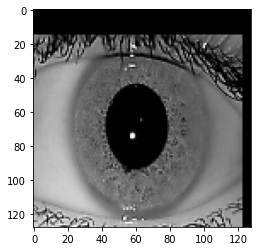

In [28]:

#plt.imshow(np.squeeze(mask_R[1]))
plt.imshow(image_R[1],cmap='gray')
plt.show()

In [29]:
out_image = np.squeeze(preds[1][1])
preds[0].shape

(4, 128, 128, 1)

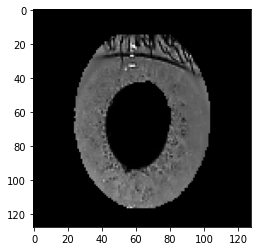

In [30]:

dummy_image = image_R[1].copy() 
dummy_image[out_image<.5] = 0
plt.imshow(dummy_image,cmap='gray')
plt.show()

In [ ]:
y = preds[2]
print(y)

## Test data for model 

In [31]:
test_out1,test_out2,test_seg1,test_seg2,y_class = read_simaese_parametric_data(path_input_images,folder_name_list_test[0:39],39)

In [32]:
test_out1 = test_out1/255.0
test_out2 = test_out2/255.0
# test_seg1 = test_seg1/255.0
# test_seg2 = test_seg2/255.0

In [33]:
[test_seg_out1,test_seg_out2, y_pred] = model.predict([test_out1,test_out2])

In [34]:
test_seg2.shape

(400, 128, 128, 1)

In [35]:
def show_images(test_out1,test_seg_out1):
    #num_images = len(test_seg_out1)
    num_images = 20
    for i in range(0,num_images,4):
        dummy_image = np.squeeze(test_out1[i]).copy()
        seg_img = np.squeeze(test_seg_out1[i])
        dummy_image[seg_img<.5] = 0
        plt.imshow(np.squeeze(test_out1[i]),cmap='gray')
        plt.show()
        plt.imshow(dummy_image,cmap='gray')
        plt.show()

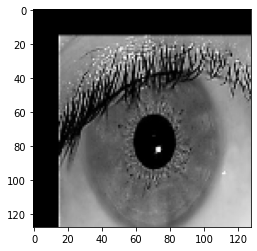

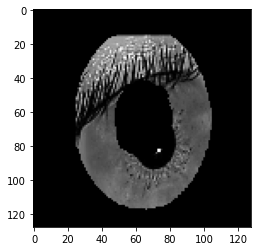

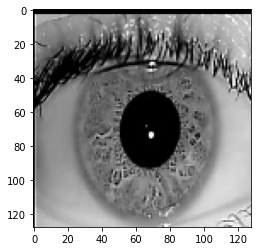

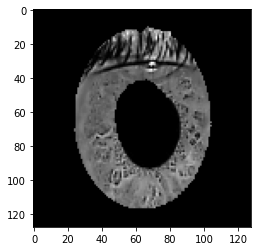

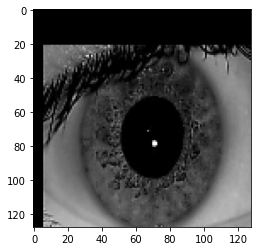

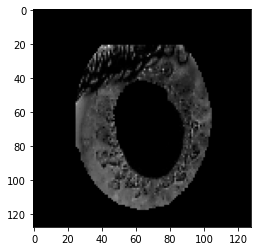

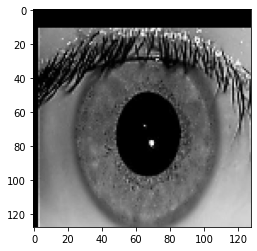

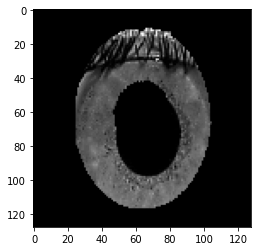

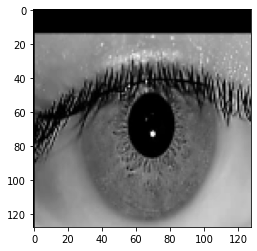

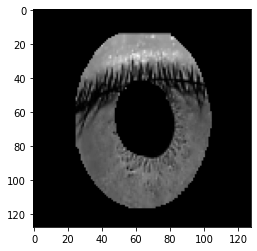

In [36]:
show_images(test_out2,test_seg_out2)

In [37]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [38]:
compute_accuracy(y_class, y_pred)      ## trained on 120 images and tested on 100 persons 

0.975

In [39]:
!{sys.executable} -m pip install -U scikit-learn scipy

     |################################| 22.2 MB 573 kB/s  eta 0:00:01
     |################################| 303 kB 11.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_class, y_pred.ravel() < 0.5)                      ##   [TN , FP]
                                                                     ##     [FN , TP] 

array([[193,   7],
       [  3, 197]])

In [101]:
def rotate_image_tensor(image, angle, mode='black'):
    """
    Rotates a 3D tensor (HWD), which represents an image by given radian angle.

    New image has the same size as the input image.

    mode controls what happens to border pixels.
    mode = 'black' results in black bars (value 0 in unknown areas)
    mode = 'white' results in value 255 in unknown areas
    mode = 'ones' results in value 1 in unknown areas
    mode = 'repeat' keeps repeating the closest pixel known
    """
    s = image.get_shape().as_list()
    assert len(s) == 3, "Input needs to be 3D."
    assert (mode == 'repeat') or (mode == 'black') or (mode == 'white') or (mode == 'ones'), "Unknown boundary mode."
    image_center = [np.floor(x/2) for x in s]

    # Coordinates of new image
    coord1 = tf.range(s[0])
    coord2 = tf.range(s[1])

    # Create vectors of those coordinates in order to vectorize the image
    coord1_vec = tf.tile(coord1, [s[1]])

    coord2_vec_unordered = tf.tile(coord2, [s[0]])
    coord2_vec_unordered = tf.reshape(coord2_vec_unordered, [s[0], s[1]])
    coord2_vec = tf.reshape(tf.transpose(coord2_vec_unordered, [1, 0]), [-1])

    # center coordinates since rotation center is supposed to be in the image center
    coord1_vec_centered = coord1_vec - image_center[0]
    coord2_vec_centered = coord2_vec - image_center[1]

    coord_new_centered = tf.cast(tf.pack([coord1_vec_centered, coord2_vec_centered]), tf.float32)

In [102]:
  image = tf.constant(np.zeros((384, 512, 5)), dtype = tf.float32)
  image = tfa.image.rotate(image, tf.random.uniform(shape = [], minval = -0.3, maxval = 0.3))

In [103]:
tf.random.uniform(shape = [], minval = -0.3, maxval = 0.3)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07962942>

In [104]:
tf.constant(0,dtype='float32')

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [105]:
128*5 # (2*np.pi/360)*   

640

In [106]:
c = tf.constant([1.0, 2.0, 3.0, 4.0])          #2x4 
d = tf.constant([3.0, 4.0, 1.0,2.0])  

In [107]:
print(concatenate([c,d],axis=0)[0:4])

tf.Tensor([1. 2. 3. 4.], shape=(4,), dtype=float32)


In [108]:
# a = tf.squeeze(tf.constant(np.zeros((None,512)),dtype=tf.float32))
a = tf.zeros([None, 4], tf.float32)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
a